In [1]:
import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

2025-09-15 17:38:08.651185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757957888.857804      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757957888.916306      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Reading Data

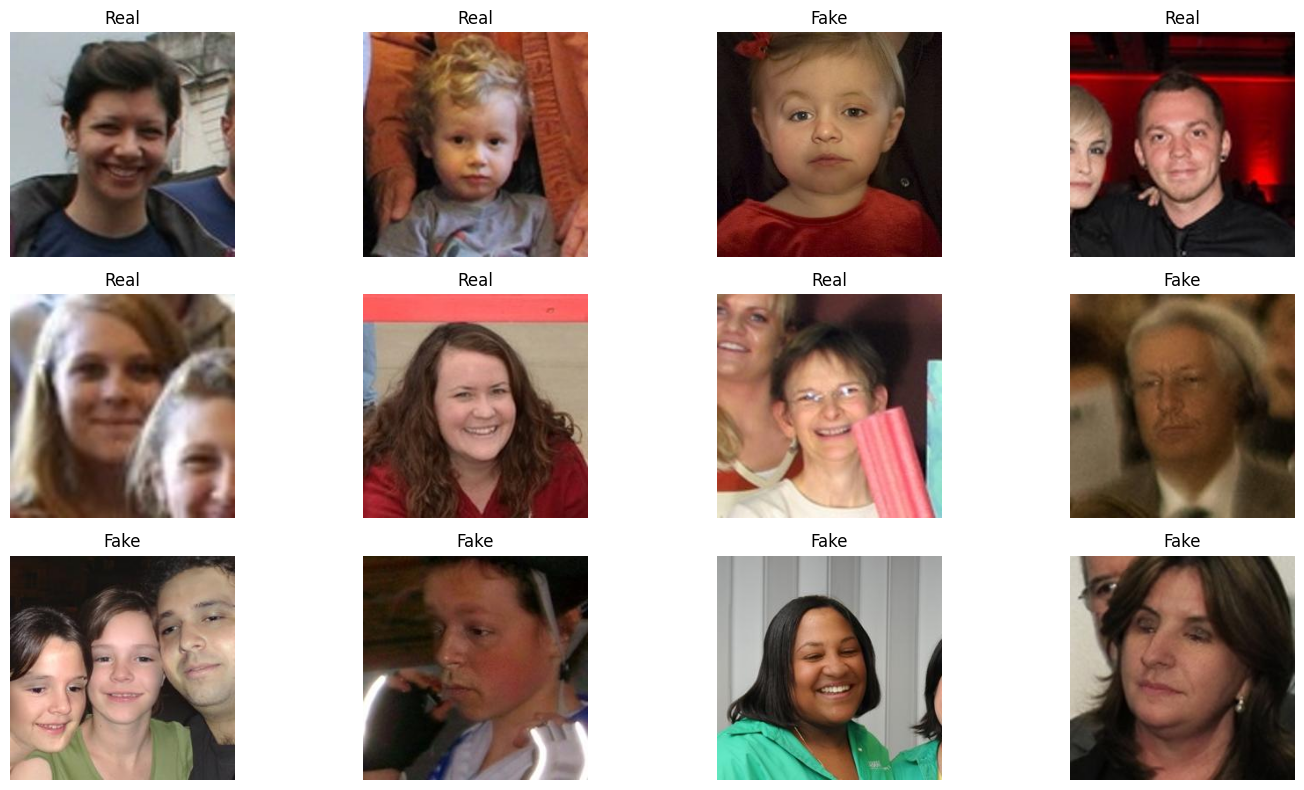

In [3]:
fake_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train/Fake"
real_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train/Real"

fake_images = random.sample(os.listdir(fake_dir), 6)
real_images = random.sample(os.listdir(real_dir), 6)

all_images = [(os.path.join(fake_dir, f), "Fake") for f in fake_images] + \
             [(os.path.join(real_dir, r), "Real") for r in real_images]

random.shuffle(all_images)

plt.figure(figsize=(15, 8))
for i, (img_path, label) in enumerate(all_images):
    plt.subplot(3, 4, i+1)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [2]:
train_data_gen = ImageDataGenerator(
    rescale = 1./255 ,
    horizontal_flip = True
)
data_gen = ImageDataGenerator( rescale = 1./255 )

In [3]:
TARGET_SIZE = (256,256)
train_generator = train_data_gen.flow_from_directory(
    directory = "/kaggle/input/deepfake-and-real-images/Dataset/Train",
    class_mode = 'binary',
    target_size = TARGET_SIZE,
    batch_size = 32,
)

val_generator = data_gen.flow_from_directory(
    directory = "/kaggle/input/deepfake-and-real-images/Dataset/Validation",
    class_mode = 'binary',
    target_size = TARGET_SIZE,
    batch_size = 32,
    shuffle = False
)

test_generator = data_gen.flow_from_directory(
    directory = "/kaggle/input/deepfake-and-real-images/Dataset/Test",
    class_mode = 'binary',
    target_size = TARGET_SIZE,
    batch_size = 32,
    shuffle = False
)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


# Custom 5 Layers CNN Model

In [9]:
model = Sequential([
    Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape = (256,256,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), padding = 'same', activation = 'relu' ),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), padding = 'same', activation = 'relu' ),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), padding = 'same', activation = 'relu' ),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), padding = 'same', activation = 'relu' ),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation = 'relu'),
    Dropout(0.5),
    Dense(1, activation = 'sigmoid'), 
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1757770234.168513      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,237,089 (8.53 MB)

 Trainable params: 2,237,089 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model_checkpoint = ModelCheckpoint(
    'CNN_best_model.h5',
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_accuracy',restore_best_weights=True, patience=5)

In [11]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
history = model.fit(train_generator, epochs = 50, validation_data = val_generator , 
                    callbacks = [model_checkpoint, early_stopping] )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1757770252.296543     122 service.cc:148] XLA service 0x7b12d8010770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757770252.297113     122 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757770252.712484     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/4376 ━━━━━━━━━━━━━━━━━━━━ 9:30:29 8s/step - accuracy: 0.5312 - loss: 0.6913

I0000 00:00:1757770256.876456     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.7588 - loss: 0.4489
Epoch 1: val_accuracy improved from -inf to 0.89213, saving model to CNN_best_model.h5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1153s 262ms/step - accuracy: 0.7588 - loss: 0.4489 - val_accuracy: 0.8921 - val_loss: 0.2571
Epoch 2/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9336 - loss: 0.1682
Epoch 2: val_accuracy improved from 0.89213 to 0.90164, saving model to CNN_best_model.h5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 484s 111ms/step - accuracy: 0.9336 - loss: 0.1682 - val_accuracy: 0.9016 - val_loss: 0.2465
Epoch 3/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9488 - loss: 0.1309
Epoch 3: val_accuracy improved from 0.90164 to 0.93033, saving model to CNN_best_model.h5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 455s 104ms/step - accuracy: 0.9488 - loss: 0.1309 - val_accuracy: 0.9303 - val_loss: 0.1762
Epoch 4/50
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9567 - loss: 0.1109
Epoch 4: val_accu

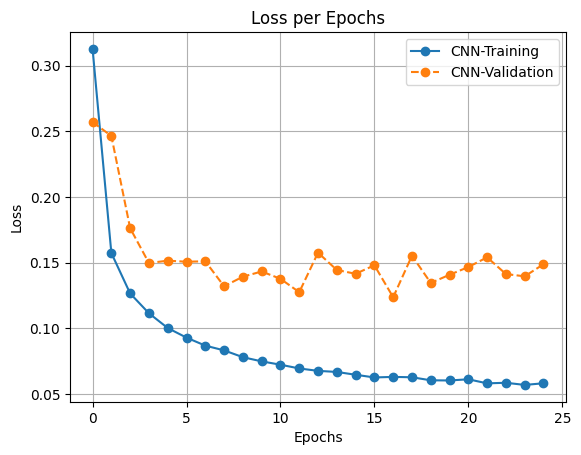

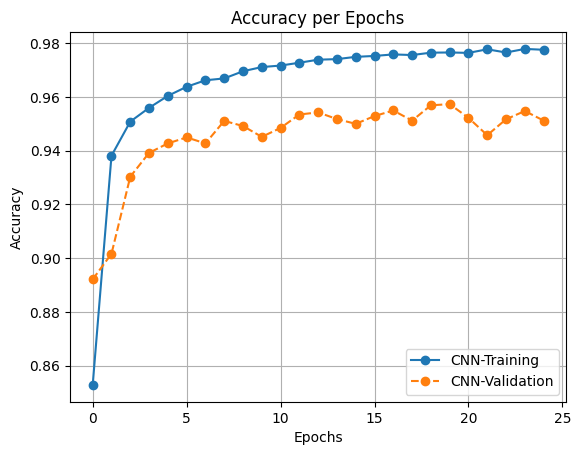

In [13]:
plt.plot(history.history['loss'], label='CNN-Training', marker='o')
plt.plot(history.history['val_loss'], label='CNN-Validation',linestyle='--', marker='o')
plt.title('Loss per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.plot(history.history['accuracy'], label='CNN-Training', marker='o')
plt.plot(history.history['val_accuracy'], label='CNN-Validation',linestyle='--', marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

341/341 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step


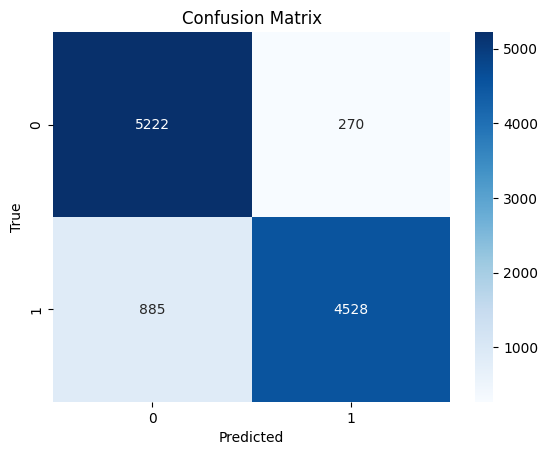

              precision    recall  f1-score   support

        Fake       0.86      0.95      0.90      5492
        Real       0.94      0.84      0.89      5413

    accuracy                           0.89     10905
   macro avg       0.90      0.89      0.89     10905
weighted avg       0.90      0.89      0.89     10905



In [16]:
y_true = test_generator.classes

y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names = test_generator.class_indices.keys()))

# ResNet50 Model

In [6]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=x)

I0000 00:00:1757848722.489965      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [7]:
model_checkpoint = ModelCheckpoint(
    'resnet_best_model.h5',
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_accuracy',restore_best_weights=True, patience=5)

In [8]:
resnet_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
resnet_history = resnet_model.fit(train_generator, epochs = 10, validation_data = val_generator , 
                    callbacks = [model_checkpoint, early_stopping] )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1757848802.046755     118 service.cc:148] XLA service 0x7f3034002150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757848802.047519     118 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757848806.643237     118 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757848828.106287     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9179 - loss: 0.2041
Epoch 1: val_accuracy improved from -inf to 0.93248, saving model to resnet_best_model.h5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 1707s 373ms/step - accuracy: 0.9179 - loss: 0.2041 - val_accuracy: 0.9325 - val_loss: 0.1646
Epoch 2/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9596 - loss: 0.1031
Epoch 2: val_accuracy did not improve from 0.93248
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 911s 208ms/step - accuracy: 0.9596 - loss: 0.1031 - val_accuracy: 0.8293 - val_loss: 0.4062
Epoch 3/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9710 - loss: 0.0734
Epoch 3: val_accuracy did not improve from 0.93248
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 947s 216ms/step - accuracy: 0.9710 - loss: 0.0733 - val_accuracy: 0.8495 - val_loss: 0.3706
Epoch 4/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9773 - loss: 0.0576
Epoch 4: val_accuracy did not improve from 0.93248
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 912s 20

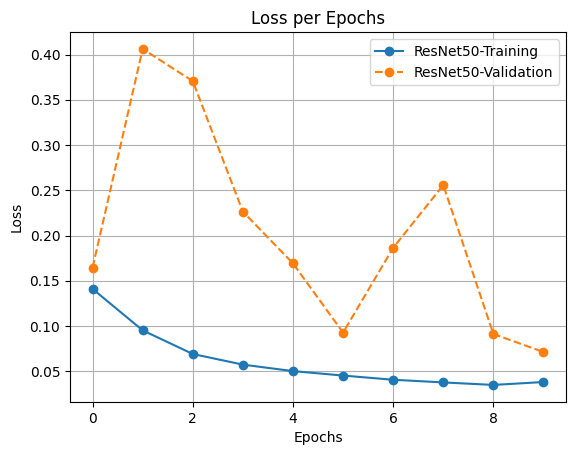

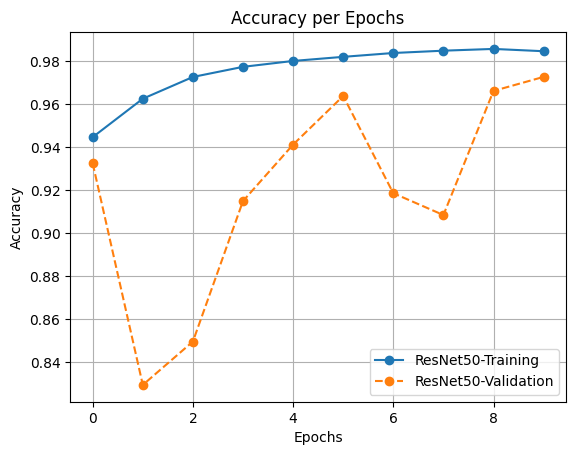

In [10]:
plt.plot(resnet_history.history['loss'], label='ResNet50-Training', marker='o')
plt.plot(resnet_history.history['val_loss'], label='ResNet50-Validation',linestyle='--', marker='o')
plt.title('Loss per Epochs') 
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.plot(resnet_history.history['accuracy'], label='ResNet50-Training', marker='o')
plt.plot(resnet_history.history['val_accuracy'], label='ResNet50-Validation',linestyle='--', marker='o')
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

341/341 ━━━━━━━━━━━━━━━━━━━━ 110s 310ms/step


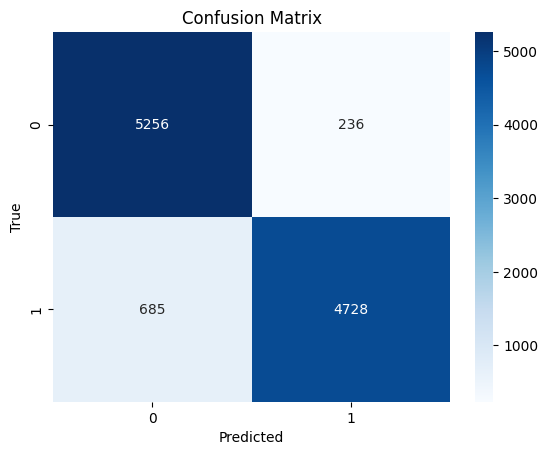

              precision    recall  f1-score   support

        Fake       0.88      0.96      0.92      5492
        Real       0.95      0.87      0.91      5413

    accuracy                           0.92     10905
   macro avg       0.92      0.92      0.92     10905
weighted avg       0.92      0.92      0.92     10905



In [11]:
y_true = test_generator.classes

y_pred_prob = resnet_model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names = test_generator.class_indices.keys()))

# Evaluating

## evaluating on the ResNet50 Model as the best validation accuarcy and loss

## accuracy: 0.9869 - loss: 0.0325 - val_accuracy: 0.9728 - val_loss: 0.0712

In [4]:
from tensorflow.keras.models import load_model

resnet_model = load_model("/kaggle/input/resnet_model/tensorflow2/default/1/resnet_best_model.h5")
resnet_model.summary()

I0000 00:00:1757958101.510936      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,363 (93.99 MB)

 Trainable params: 24,585,217 (93.79 MB)

 Non-trainable params: 54,144 (211.50 KB)

 Optimizer params: 2 (12.00 B)

In [5]:
test_loss, test_accuracy = resnet_model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1757958123.526140     120 service.cc:148] XLA service 0x7ab64c04c0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757958123.527123     120 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757958124.280399     120 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/341 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.9688 - loss: 0.0570 

I0000 00:00:1757958128.153989     120 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


341/341 ━━━━━━━━━━━━━━━━━━━━ 96s 251ms/step - accuracy: 0.9506 - loss: 0.1307
Test Loss: 0.23858541250228882
Test Accuracy: 91.55%


341/341 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step


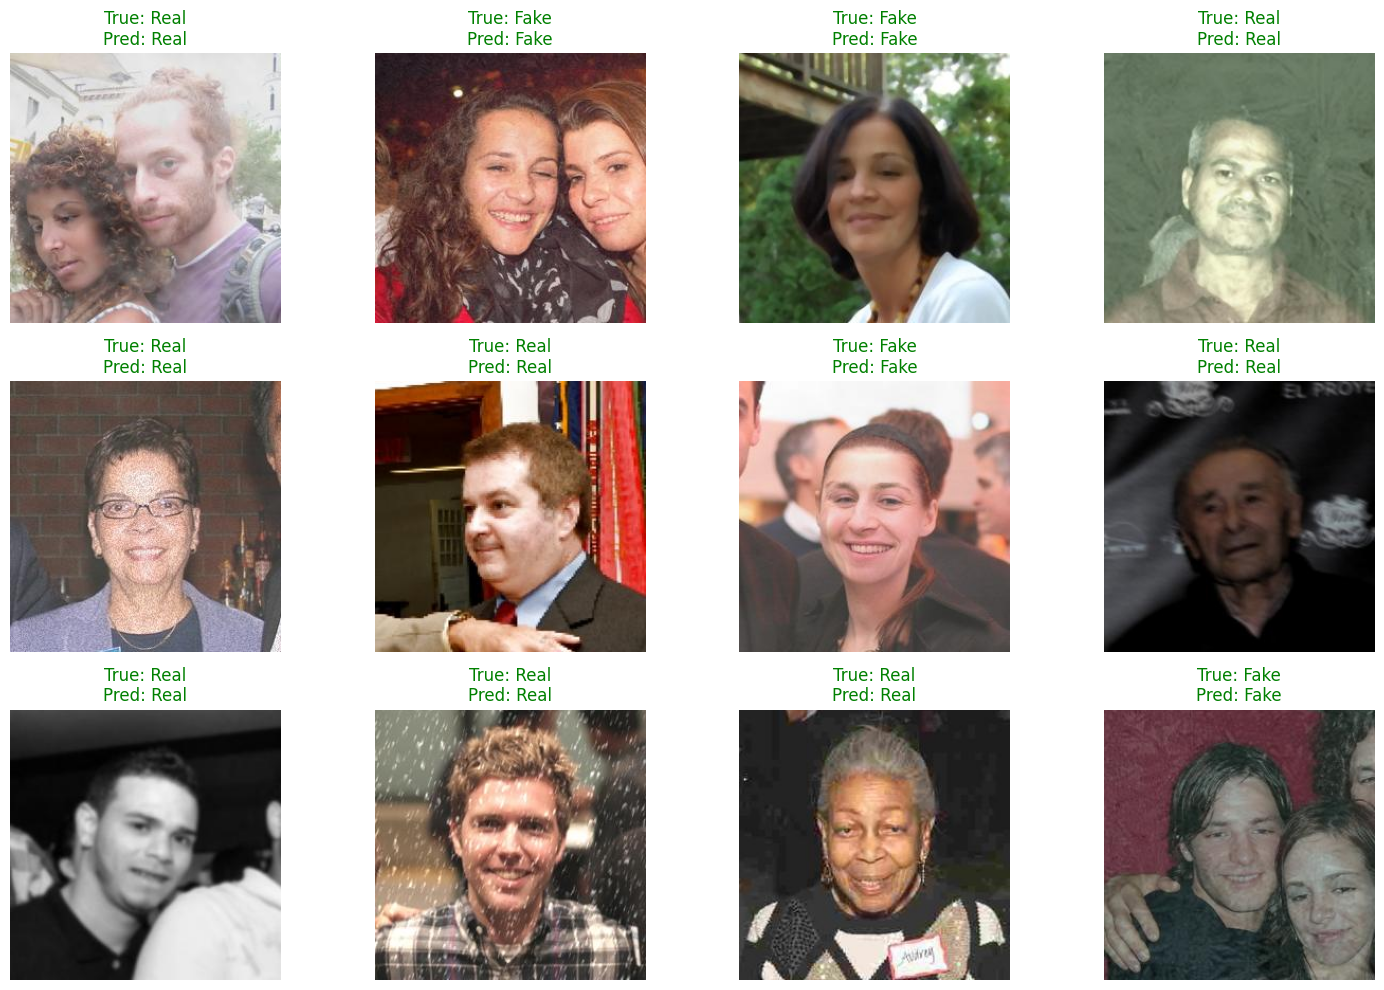

In [8]:
# Step 1: Reset generator so predictions align with labels
test_generator.reset()

# Step 2: Get true labels and predicted probabilities
y_true = test_generator.classes
y_pred_prob = resnet_model.predict(test_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Step 3: Get class names in correct order
class_names = list(test_generator.class_indices.keys())

# Step 4: Pick random 12 indices
indices = np.random.choice(len(y_true), size=12, replace=False)

# Step 5: Plot images with true & predicted labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices):
    img_path = test_generator.filepaths[idx]  # path of image
    img = plt.imread(img_path)

    plt.subplot(3, 4, i+1)
    plt.imshow(img.astype("uint8"))
    
    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    
    # Title shows True vs Pred
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [9]:
def grad_cam_heatmap(image_array, model, last_conv_name):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(last_conv_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image_array)
        pred_index = tf.argmax(predictions[0])
        top_class = predictions[:, pred_index]

    grads = tape.gradient(top_class, conv_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_output[:,:,i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis = -1)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)

    return heatmap, pred_index.numpy()

In [10]:
from matplotlib import cm
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array

def superimposed_img(image, heatmap, alpha = 0.4):
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[1], image.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + image
    superimposed_img = array_to_img(superimposed_img)
    return superimposed_img

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)
/tmp/ipykernel_36/559023159.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


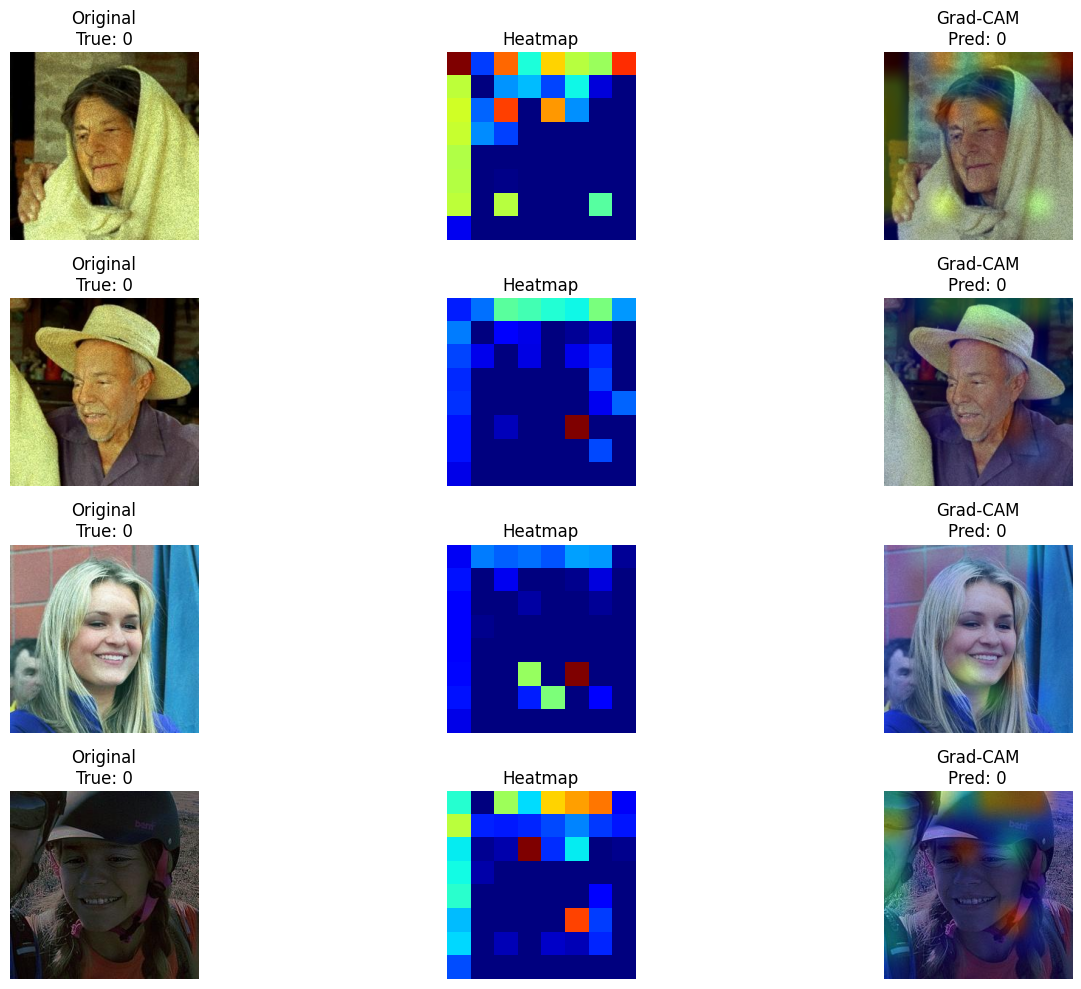

In [11]:
image_batch , label_batch = next(iter(test_generator))
num_images = 4 
last_conv_layer_name = 'conv5_block3_out'

plt.figure(figsize=(15,10))

for i in range(num_images):
    img = image_batch[i]
    img_array = np.expand_dims(img, axis=0)

    heatmap , pred_index = grad_cam_heatmap(img_array, resnet_model, last_conv_layer_name)

    overlay = superimposed_img(img*255, heatmap)

    plt.subplot(num_images, 3, 3*i + 1)
    plt.imshow(img)
    plt.title(f"Original\nTrue: {np.argmax(label_batch[i])}")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title("Heatmap")
    plt.axis("off")

    plt.subplot(num_images, 3, 3*i + 3)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM\nPred: {pred_index}")
    plt.axis("off")

plt.tight_layout()
plt.show()